In [1]:
%cd ../..

C:\Users\Wight\PycharmProjects\ViCCT


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import os
import models.ViCCT_models  # Need to register the models!
from timm.models import create_model
from datasets.dataset_utils import img_equal_unsplit
import importlib
import time

In [3]:
model_name = 'ViCCT_base'  # Must be something like 'deit_small_distilled_patch16_224'.
model_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\ViCCT base most public\\save_state_ep_350.pth'
label_factor = 3000  # The label factor used to train this specific model.
dataset = 'Generic_ViCCT'  # Must be the exact name of the dataset
save_results = False  # When true, save the images, GTs and predictions. A folder for this is created automatically.
set_to_eval = 'test'  # val', 'test'. Which split to test the model on. 'train' does not work!

In [4]:
model = create_model(
        model_name,
        init_path=None,
        num_classes=1000,  # Not yet used anyway. Must match pretrained model!
        drop_rate=0.,
        drop_path_rate=0.,  
        drop_block_rate=None,
    )

model.cuda()

resume_state = torch.load(model_path)
model.load_state_dict(resume_state['net'])

model.eval()

DistilledRegressionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attenti

In [5]:
dataloader = importlib.import_module(f'datasets.{dataset}.loading_data').loading_data
cfg_data = importlib.import_module(f'datasets.{dataset}.settings').cfg_data

train_loader, val_loader, test_loader, restore_transform = dataloader(model.crop_size)
if set_to_eval == 'val':
    my_dataloader = val_loader
elif set_to_eval == 'test':
    my_dataloader = test_loader
else:
    print(f'Error: invalid set --> {set_to_eval}')


Constructing combined train dataset
  Added dataset "ShanghaiTech_Part_B" with 320 images
320 train images found in 1 datasets.

Constructing combined val dataset
  Added dataset "ShanghaiTech_Part_B" with 80 images
80 val images found in 1 datasets.

Constructing combined test dataset
  Added dataset "ShanghaiTech_Part_A" with 182 images
182 test images found in 1 datasets.


In [6]:
save_path = None
if save_results:
    save_folder = 'DeiT' + '_' + dataset + '_' + set_to_eval + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_path = os.path.join('notebooks', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_path)

In [7]:
def plot_and_save_results(save_path, img, img_idx, gt, prediction, pred_cnt, gt_cnt):
    img_save_path = os.path.join(save_path, f'IMG_{img_idx}_AE_{abs(pred_cnt - gt_cnt):.3f}.jpg')
    
    plt.figure()
    f, axarr = plt.subplots(1, 3, figsize=(13, 13))
    axarr[0].imshow(img)
    axarr[1].imshow(gt, cmap=cm.jet)
    axarr[1].title.set_text(f'GT count: {gt_cnt:.3f}')
    axarr[2].imshow(prediction, cmap=cm.jet)
    axarr[2].title.set_text(f'predicted count: {pred_cnt:.3f}')
    plt.tight_layout()
    plt.savefig(img_save_path)
    plt.close('all')

In [8]:
def eval_model(model, my_dataloader, show_predictions, restore_transform, label_factor, cfg_data):
    with torch.no_grad():
        AEs = []  # Absolute Errors
        SEs = []  # Squared Errors
        GTs = []
        preds = []

        for idx, (img, img_patches, gt_patches) in enumerate(my_dataloader):
            img_patches = img_patches.squeeze().cuda()
            gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
            img = img.squeeze()  # Remove batch dimension
            _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction
            
            img = restore_transform(img)

            pred_den = model(img_patches)  # Precicted density crops
            pred_den = pred_den.cpu()

            # Restore GT and Prediction
            gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim
            
            
            pred_cnt = den.sum() / label_factor
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            GTs.append(gt_cnt.item())
            preds.append(pred_cnt.item())
            relative_error = AEs[-1] / gt_cnt * 100
            print(f'IMG {idx:<3} '
                  f'Prediction: {pred_cnt:<9.3f} '
                  f'GT: {gt_cnt:<9.3f} '
                  f'Absolute Error: {AEs[-1]:<9.3f} '
                  f'Relative Error: {relative_error:.1f}%')
            
            if save_path:
                plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))

    return MAE, MSE, GTs, preds

In [9]:
MAE, MSE, GTs, preds = eval_model(model, my_dataloader, save_path, restore_transform, label_factor, cfg_data)
print(f'MAE/MSE: {MAE:.3f}/{MSE:.3f}')

IMG 0   Prediction: 220.955   GT: 172.000   Absolute Error: 48.955    Relative Error: 28.5%
IMG 1   Prediction: 489.068   GT: 499.404   Absolute Error: 10.336    Relative Error: 2.1%
IMG 2   Prediction: 405.187   GT: 386.685   Absolute Error: 18.502    Relative Error: 4.8%
IMG 3   Prediction: 168.154   GT: 210.930   Absolute Error: 42.776    Relative Error: 20.3%
IMG 4   Prediction: 224.636   GT: 221.389   Absolute Error: 3.248     Relative Error: 1.5%
IMG 5   Prediction: 521.768   GT: 429.751   Absolute Error: 92.018    Relative Error: 21.4%
IMG 6   Prediction: 1389.668  GT: 1168.637  Absolute Error: 221.031   Relative Error: 18.9%
IMG 7   Prediction: 230.177   GT: 262.359   Absolute Error: 32.182    Relative Error: 12.3%
IMG 8   Prediction: 1126.823  GT: 1228.683  Absolute Error: 101.860   Relative Error: 8.3%
IMG 9   Prediction: 164.093   GT: 288.532   Absolute Error: 124.439   Relative Error: 43.1%
IMG 10  Prediction: 176.382   GT: 180.507   Absolute Error: 4.125     Relative Error

IMG 90  Prediction: 294.967   GT: 397.164   Absolute Error: 102.197   Relative Error: 25.7%
IMG 91  Prediction: 229.397   GT: 215.393   Absolute Error: 14.004    Relative Error: 6.5%
IMG 92  Prediction: 185.975   GT: 198.894   Absolute Error: 12.919    Relative Error: 6.5%
IMG 93  Prediction: 216.094   GT: 229.634   Absolute Error: 13.540    Relative Error: 5.9%
IMG 94  Prediction: 1165.851  GT: 1109.528  Absolute Error: 56.323    Relative Error: 5.1%
IMG 95  Prediction: 461.369   GT: 459.099   Absolute Error: 2.269     Relative Error: 0.5%
IMG 96  Prediction: 575.789   GT: 715.450   Absolute Error: 139.661   Relative Error: 19.5%
IMG 97  Prediction: 251.603   GT: 211.950   Absolute Error: 39.654    Relative Error: 18.7%
IMG 98  Prediction: 395.578   GT: 429.000   Absolute Error: 33.422    Relative Error: 7.8%
IMG 99  Prediction: 543.328   GT: 552.883   Absolute Error: 9.555     Relative Error: 1.7%
IMG 100 Prediction: 175.747   GT: 242.813   Absolute Error: 67.066    Relative Error: 2

IMG 180 Prediction: 154.076   GT: 152.089   Absolute Error: 1.987     Relative Error: 1.3%
IMG 181 Prediction: 211.052   GT: 241.568   Absolute Error: 30.516    Relative Error: 12.6%
MAE/MSE: 66.081/128.308


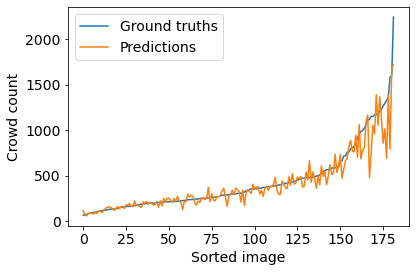

In [10]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

IMG 73, pred: 790.712, gt: 1580.524. Error: -789.812


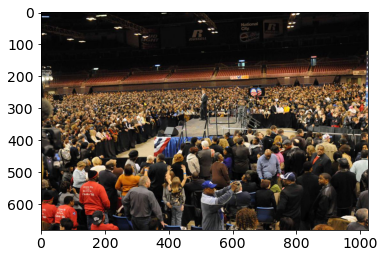

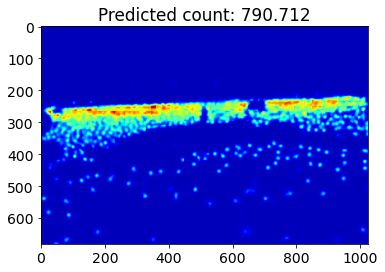

IMG 142, pred: 477.494, gt: 1117.321. Error: -639.827


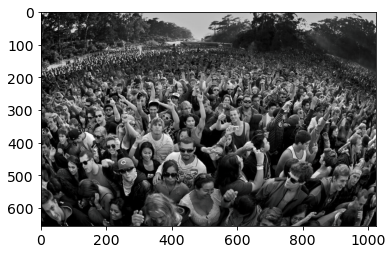

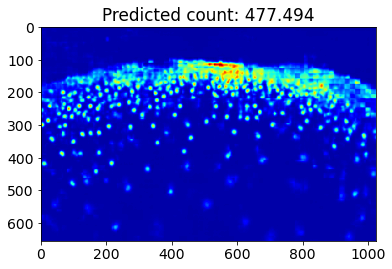

IMG 160, pred: 688.661, gt: 1323.932. Error: -635.271


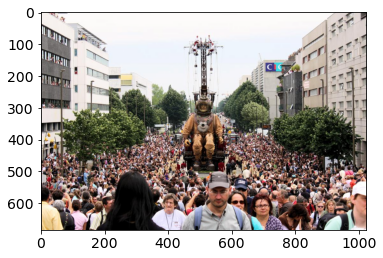

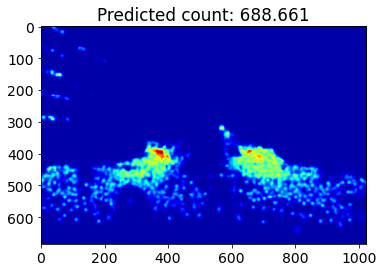

IMG 172, pred: 1719.951, gt: 2242.170. Error: -522.219


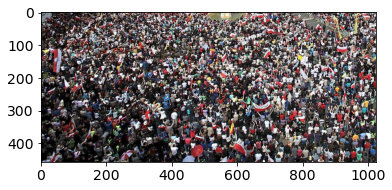

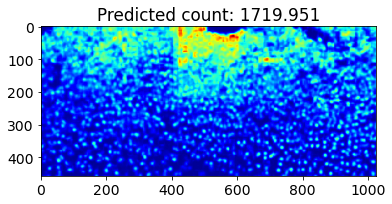

IMG 112, pred: 856.956, gt: 1264.166. Error: -407.209


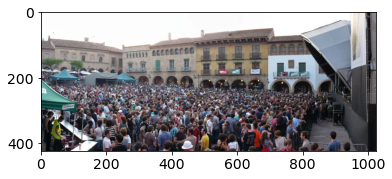

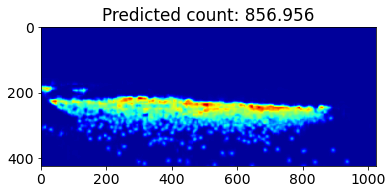

IMG 26, pred: 753.472, gt: 1149.125. Error: -395.653


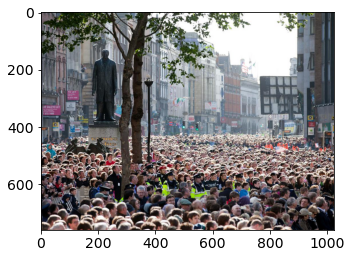

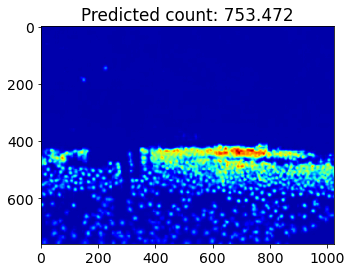

IMG 31, pred: 685.203, gt: 985.178. Error: -299.976


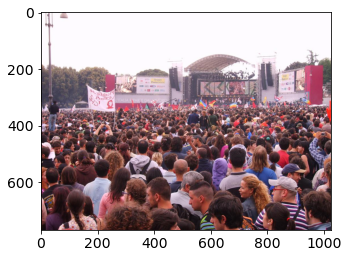

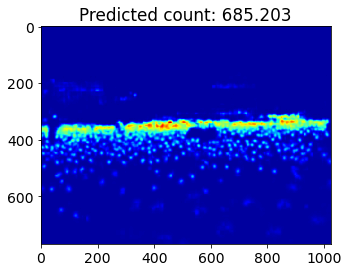

IMG 57, pred: 1014.214, gt: 1296.224. Error: -282.010


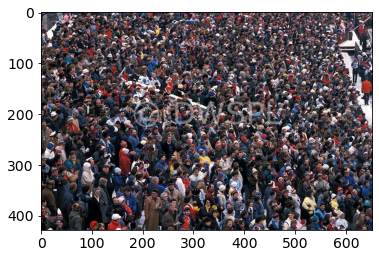

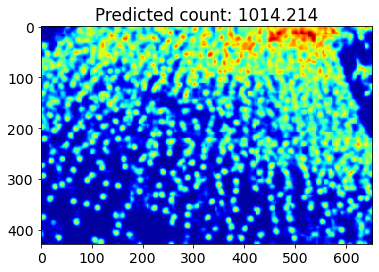

IMG 6, pred: 1389.668, gt: 1168.637. Error: 221.031


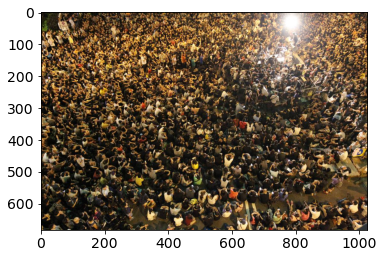

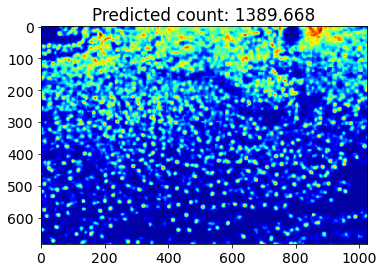

IMG 35, pred: 701.144, gt: 919.265. Error: -218.120


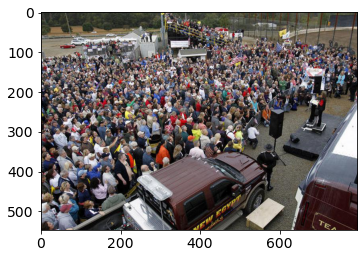

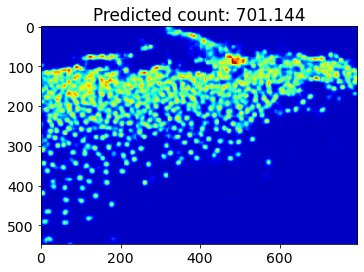

In [11]:
sorted_error_idxs = np.flip(np.argsort(np.abs(GTs - preds)))

with torch.no_grad():
    for idx in sorted_error_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()

IMG 75, pred: 110.269, gt: 110.160. Error: 0.109


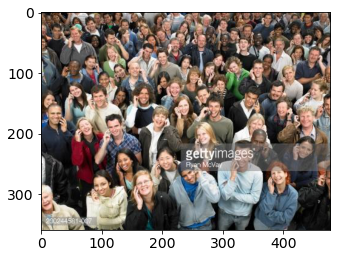

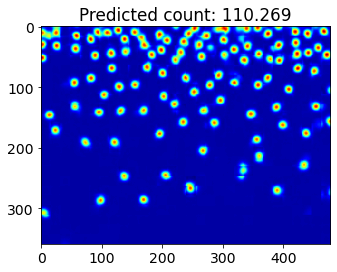

IMG 105, pred: 296.007, gt: 296.223. Error: -0.215


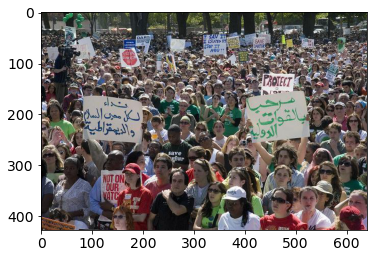

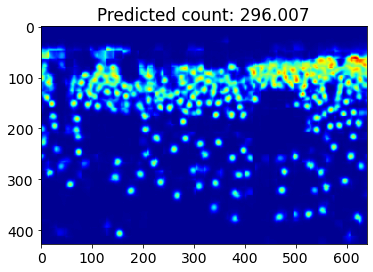

IMG 122, pred: 137.040, gt: 137.613. Error: -0.573


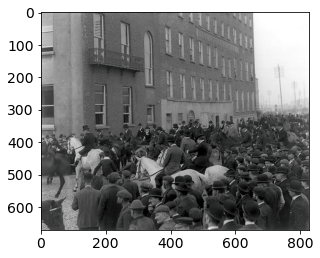

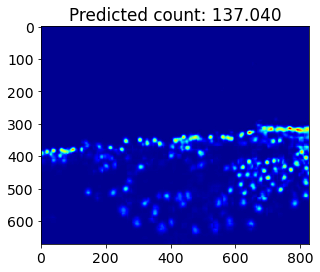

IMG 175, pred: 252.811, gt: 253.748. Error: -0.937


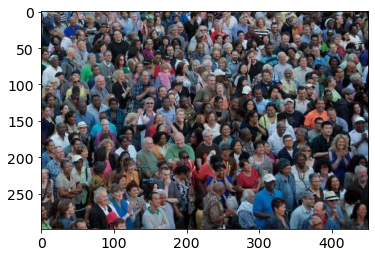

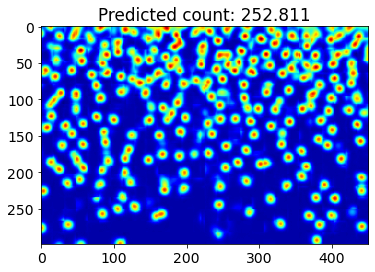

IMG 176, pred: 66.652, gt: 67.730. Error: -1.078


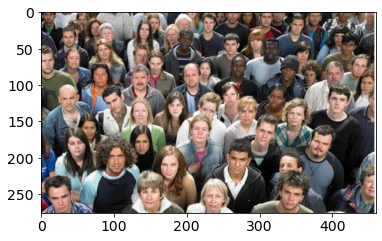

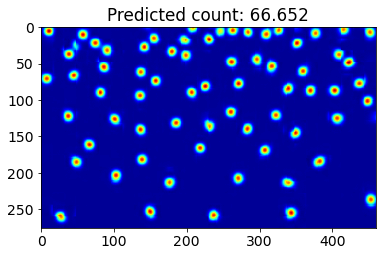

IMG 27, pred: 113.310, gt: 114.559. Error: -1.250


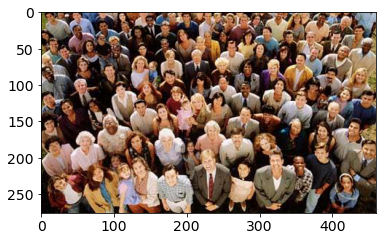

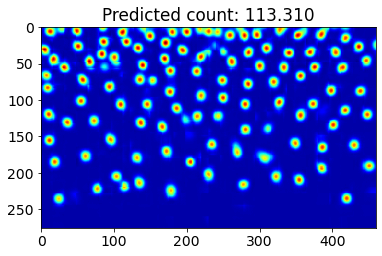

IMG 170, pred: 378.621, gt: 380.060. Error: -1.439


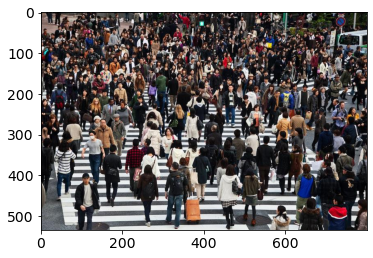

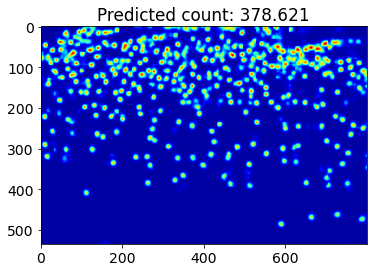

IMG 110, pred: 89.209, gt: 87.549. Error: 1.659


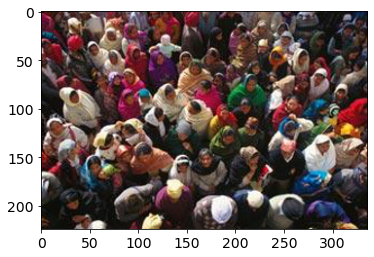

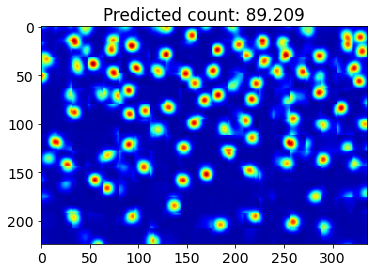

IMG 158, pred: 268.801, gt: 270.737. Error: -1.936


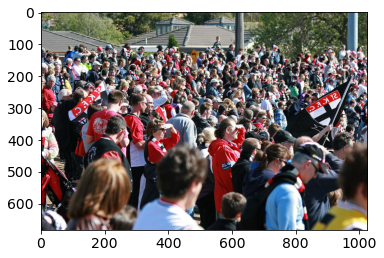

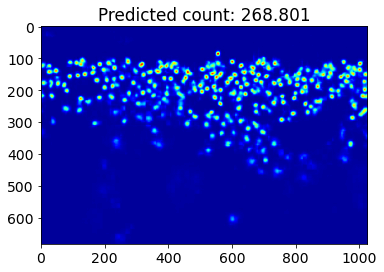

IMG 180, pred: 154.076, gt: 152.089. Error: 1.987


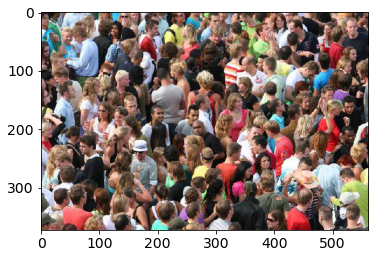

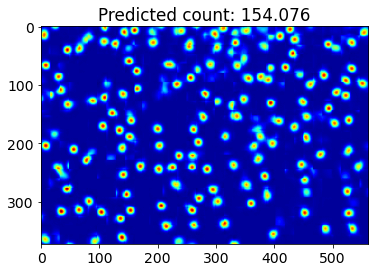

In [12]:
sorted_good_idxs = np.argsort(np.abs(GTs - preds))

with torch.no_grad():
    for idx in sorted_good_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()